In [22]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt

import multiprocessing
multiprocessing.cpu_count()

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from boruta import BorutaPy as boruta

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

import math
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
train = pd.read_csv('../Details/dataset/train.csv', index_col=False)
test  = pd.read_csv('../Details/dataset/test.csv', index_col=False)

In [4]:
pp.ProfileReport(train)

In [5]:
train.describe()

,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,250183.425697,0.504749,0.494073,0.516632,0.474235,0.504848,0.502257,0.488229,0.501739,0.488074,0.469496,0.508230,0.264870
std,144320.334812,0.206788,0.213037,0.214851,0.216636,0.227474,0.241243,0.211335,0.203496,0.179048,0.194516,0.203393,0.441265
min,0.000000,-0.049562,0.084480,0.094493,-0.045316,0.168071,-0.036379,0.005199,0.090901,0.024139,0.214866,0.097789,0.000000
25%,125399.750000,0.344985,0.317363,0.326047,0.292249,0.279303,0.276442,0.323914,0.353054,0.358915,0.309934,0.368312,0.000000
50%,250192.500000,0.479650,0.463170,0.471247,0.387564,0.479858,0.554768,0.518089,0.435404,0.410908,0.407477,0.446576,0.000000
75%,375246.250000,0.637657,0.693992,0.704625,0.644950,0.725779,0.735225,0.608537,0.642023,0.612725,0.586793,0.581957,1.000000
max,499999.000000,1.004559,1.009958,1.016600,0.952187,0.858578,0.853022,0.966553,1.035818,1.055885,1.005652,1.011331,1.000000


In [6]:
train['target'].value_counts(1)

0    0.73513
1    0.26487
Name: target, dtype: float64

## Numerical Columns

In [7]:
obj_col = [i for i in train.columns if train[i].dtype=="O"]
num_col = [i for i in train.columns if train[i].dtype!="O"]
len(obj_col), len(num_col)

(19, 13)

In [8]:
num_col.remove('id')
num1 = num_col[0: (len(num_col)//2)]
num1.append('target')
num2 = num_col[len(num_col)//2:len(num_col)]
print(num1, num2)

['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'target'] ['cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'target']


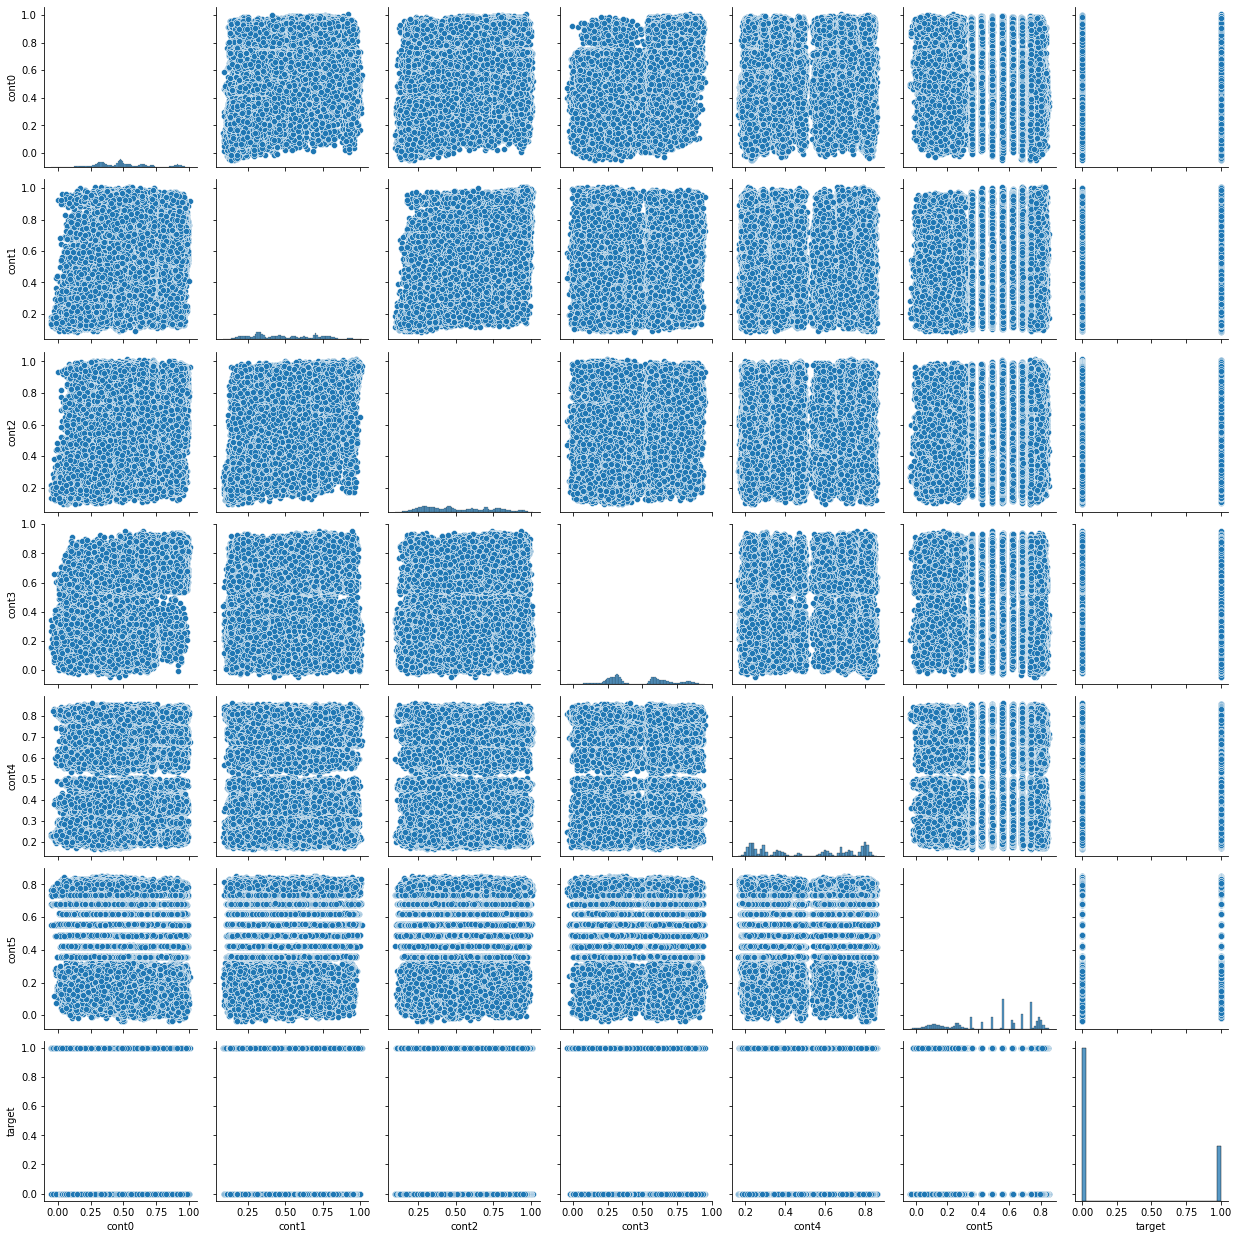

In [9]:
sns.pairplot(train[num1])

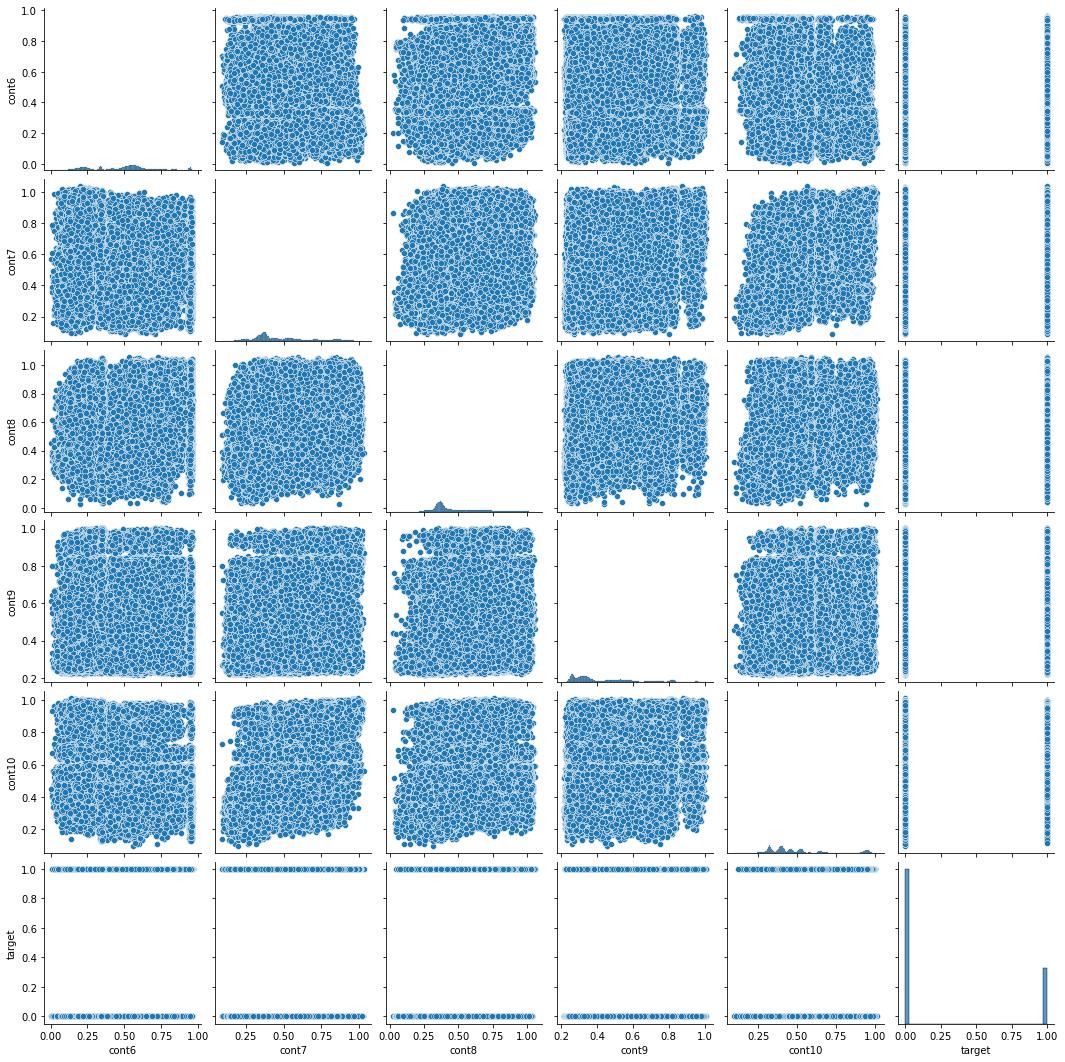

In [10]:
sns.pairplot(train[num2])

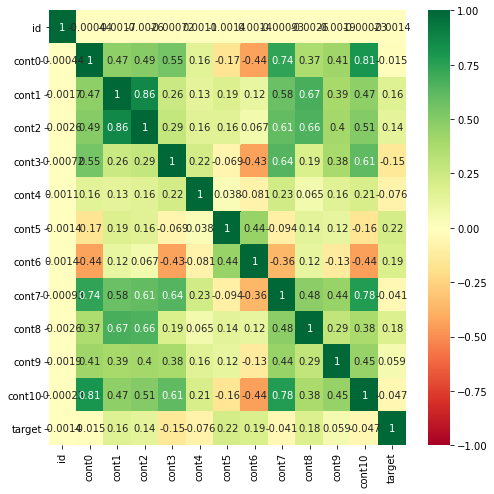

In [11]:
fig = plt.figure(figsize=(8,8))
per_corr = train.corr(method='pearson')
sns.heatmap(per_corr, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.show()

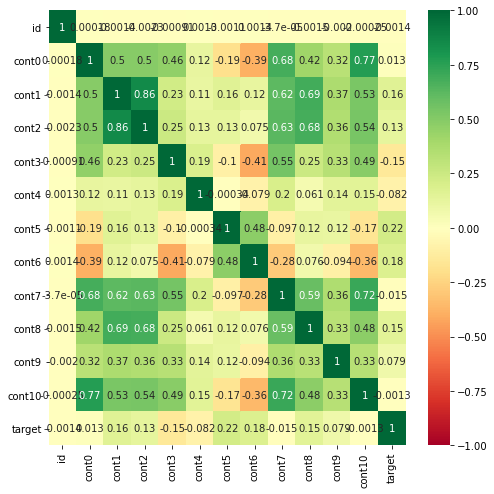

In [12]:
fig = plt.figure(figsize=(8,8))
spear_corr = train.corr(method='spearman')
sns.heatmap(spear_corr, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.show()

In [13]:
num_col.remove('target')

<AxesSubplot:>

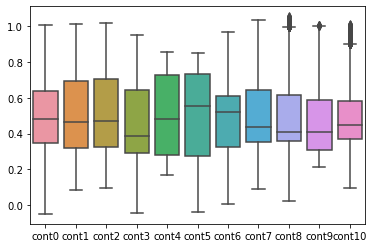

In [14]:
sns.boxplot(data=train[num_col], orient="y")

<AxesSubplot:>

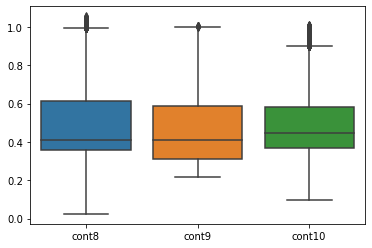

In [15]:
sns.boxplot(data=train[num_col[-3:]], orient="y")

In [16]:
print(train[train.cont8 > np.percentile(train['cont8'], 95)]['cont8'].describe())

count    15000.000000
mean         0.932824
std          0.054163
min          0.833643
25%          0.883570
50%          0.944465
75%          0.977311
max          1.055885
Name: cont8, dtype: float64


In [17]:
print(train[train.cont9 > np.percentile(train['cont9'], 95)]['cont9'].describe())

count    15000.000000
mean         0.915154
std          0.052309
min          0.829933
25%          0.870363
50%          0.934853
75%          0.958691
max          1.005652
Name: cont9, dtype: float64


In [18]:
print(train[train.cont10 > np.percentile(train['cont10'], 95)]['cont10'].describe())

count    15000.000000
mean         0.964141
std          0.010676
min          0.950123
25%          0.955581
50%          0.961882
75%          0.970456
max          1.011331
Name: cont10, dtype: float64


<AxesSubplot:title={'center':'Cont 10'}, xlabel='cont10', ylabel='Count'>

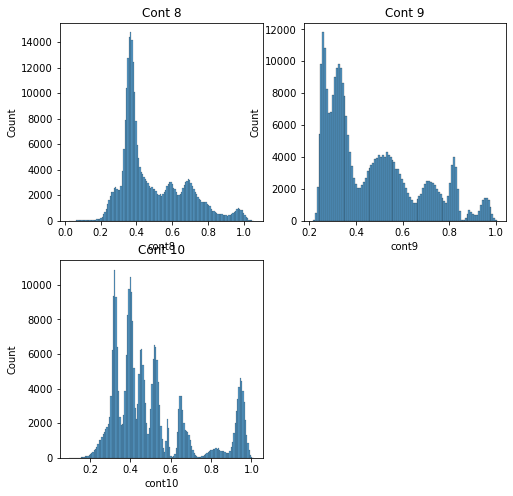

In [19]:
fig = plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.title('Cont 8')
sns.histplot(train['cont8'])

plt.subplot(2,2,2)
plt.title('Cont 9')
sns.histplot(train['cont9'])

plt.subplot(2,2,3)
plt.title('Cont 10')
sns.histplot(train['cont10'])

In [20]:
train.groupby(['target', 'cat0'])['cat0'].count()

target  cat0
0       A       148852
        B        71687
1       A        74673
        B         4788
Name: cat0, dtype: int64

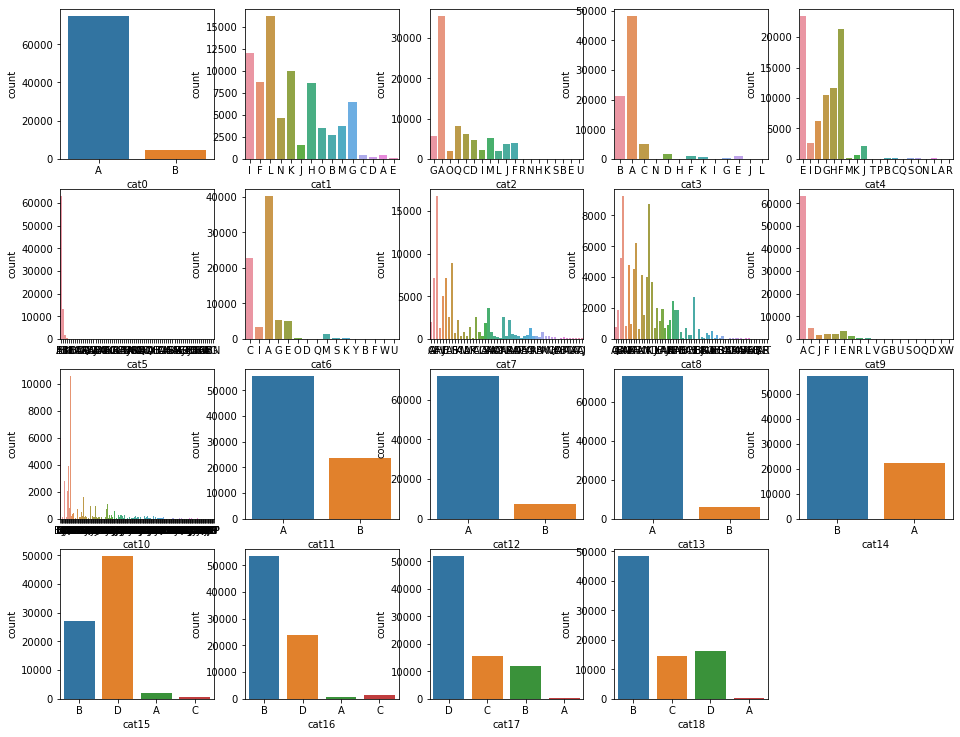

In [23]:
grid_dim = math.ceil(np.sqrt(19))
fig = plt.figure(figsize=(16, 16))
df = train[train['target']==1]

for i in range(len(obj_col)):
    plt.subplot(grid_dim, grid_dim, i+1)
    sns.countplot(x=obj_col[i], data=df)
    plt.xlabel(obj_col[i])
plt.show()

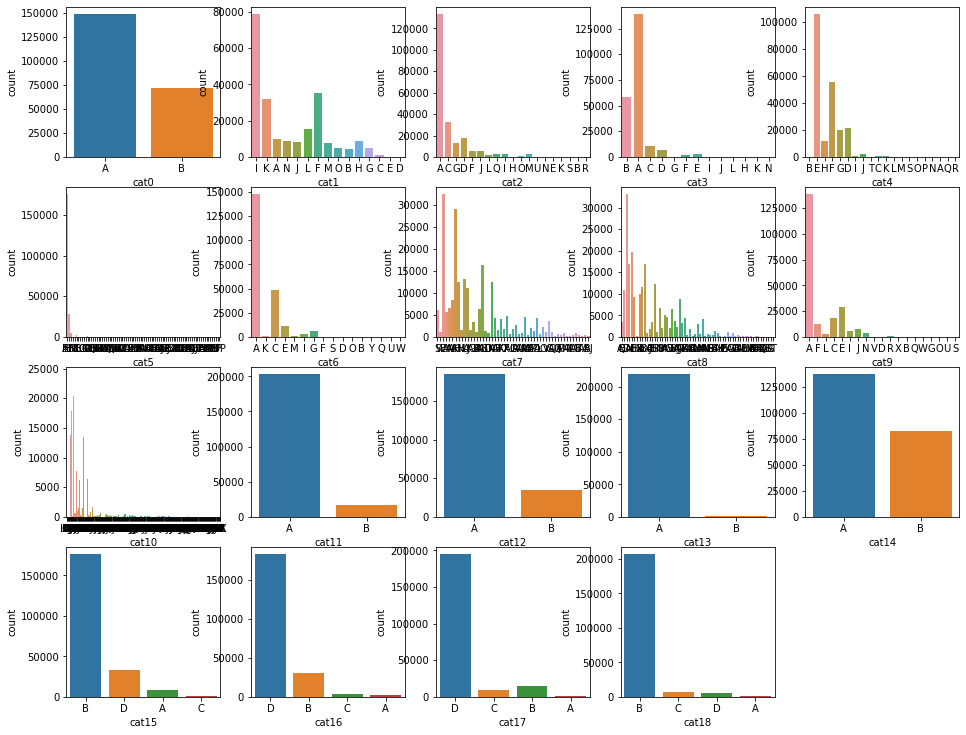

In [24]:
grid_dim = math.ceil(np.sqrt(19))
fig = plt.figure(figsize=(16, 16))
df = train[train['target']==0]

for i in range(len(obj_col)):
    plt.subplot(grid_dim, grid_dim, i+1)
    sns.countplot(x=obj_col[i], data=df)
    plt.xlabel(obj_col[i])
plt.show()

## Categorical Columns

In [25]:
for i in obj_col:
    print("{}\n{} -- {}".format(i, train[i].unique(), train[i].nunique()))

cat0
['A' 'B'] -- 2
cat1
['I' 'K' 'A' 'F' 'L' 'N' 'J' 'M' 'O' 'B' 'H' 'G' 'C' 'D' 'E'] -- 15
cat2
['A' 'G' 'C' 'O' 'D' 'F' 'Q' 'J' 'L' 'I' 'M' 'H' 'U' 'N' 'R' 'E' 'K' 'S'
 'B'] -- 19
cat3
['B' 'A' 'C' 'D' 'G' 'N' 'H' 'F' 'E' 'K' 'I' 'J' 'L'] -- 13
cat4
['B' 'E' 'H' 'I' 'D' 'F' 'G' 'M' 'K' 'J' 'T' 'C' 'L' 'P' 'S' 'O' 'N' 'Q'
 'A' 'R'] -- 20
cat5
['BI' 'AB' 'BU' 'M' 'T' 'K' 'L' 'CG' 'BG' 'CI' 'N' 'G' 'X' 'Q' 'O' 'BO'
 'BB' 'BX' 'AF' 'BA' 'BQ' 'CA' 'D' 'AQ' 'AS' 'AW' 'BE' 'CK' 'AL' 'BK' 'AT'
 'CL' 'C' 'CF' 'I' 'AH' 'CD' 'AY' 'BY' 'F' 'AI' 'R' 'BC' 'BH' 'AA' 'V'
 'CE' 'BD' 'AE' 'U' 'AU' 'AP' 'CJ' 'AN' 'AX' 'AR' 'BL' 'J' 'ZZ' 'BR' 'BV'
 'H' 'A' 'CC' 'P' 'CH' 'BJ' 'CB' 'BS' 'BN' 'AO' 'AJ' 'BT' 'S' 'E' 'Y' 'AK'
 'AM' 'B' 'BM' 'AV' 'AG' 'BF' 'BP'] -- 84
cat6
['A' 'K' 'C' 'I' 'G' 'E' 'M' 'F' 'O' 'D' 'Q' 'S' 'B' 'Y' 'U' 'W'] -- 16
cat7
['S' 'W' 'E' 'Y' 'G' 'AV' 'AF' 'AK' 'AH' 'AN' 'J' 'H' 'U' 'AG' 'AS' 'AA'
 'B' 'F' 'AI' 'K' 'AD' 'D' 'N' 'I' 'AW' 'AY' 'AX' 'L' 'AL' 'C' 'R' 'P'
 'AU' 'O' 'AR' 'AO

In [26]:
for i in [0,11,12,13,14,15,16,17,18]:
    print('cat'+str(i))
    print(train['cat'+str(i)].value_counts(1))

cat0
A    0.745083
B    0.254917
Name: cat0, dtype: float64
cat11
A    0.863107
B    0.136893
Name: cat11, dtype: float64
cat12
A    0.85713
B    0.14287
Name: cat12, dtype: float64
cat13
A    0.975707
B    0.024293
Name: cat13, dtype: float64
cat14
A    0.533887
B    0.466113
Name: cat14, dtype: float64
cat15
B    0.678580
D    0.277293
A    0.036907
C    0.007220
Name: cat15, dtype: float64
cat16
D    0.689687
B    0.281803
C    0.017897
A    0.010613
Name: cat16, dtype: float64
cat17
D    0.823750
B    0.087120
C    0.084417
A    0.004713
Name: cat17, dtype: float64
cat18
B    0.851607
D    0.074647
C    0.071380
A    0.002367
Name: cat18, dtype: float64


In [27]:
cat_col_nc = ['cat0','cat1','cat2','cat3','cat4','cat11','cat12','cat13','cat14','cat15','cat16','cat17','cat18']
cat_col_hc = ['cat5','cat6','cat8','cat7','cat9','cat10']

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [29]:
def high_cardinal_transformer(cols, df):
    for i in cols:
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
        sc = StandardScaler()
        df[[i]] = sc.fit_transform(df[[i]])

In [30]:
high_cardinal_transformer(cat_col_hc, train)
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,0.260957,-0.596674,1.476287,1.083442,-0.582026,1.591068,A,A,A,A,B,D,D,B,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,0.260957,3.185640,1.764481,-1.600443,1.229905,0.281672,A,B,A,B,D,B,D,B,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,0.260957,-0.596674,0.467610,0.241439,2.679450,-0.986805,A,B,A,A,B,D,D,B,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,0.260957,-0.596674,1.908578,-1.600443,1.229905,1.359195,A,A,A,A,B,D,D,B,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,0.260957,0.348904,0.611707,1.083442,-0.582026,-0.904968,A,A,A,B,B,B,D,B,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [31]:
def low_cardinal_transformer(cols, df):
    for i in cols:
        dummies = pd.get_dummies(df[i])
        col_list = [i+'_'+x for x in dummies.columns]
        dummies.columns = col_list
        df = pd.concat([df, dummies], axis=1)
        df.drop([i], axis=1, inplace=True)
    return df

In [32]:
train = low_cardinal_transformer(cat_col_nc, train)
train.head()

,id,cat5,cat6,cat7,cat8,cat9,cat10,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target,cat0_A,cat0_B,cat1_A,cat1_B,cat1_C,cat1_D,cat1_E,cat1_F,cat1_G,cat1_H,cat1_I,cat1_J,cat1_K,cat1_L,cat1_M,cat1_N,cat1_O,cat2_A,cat2_B,cat2_C,cat2_D,cat2_E,cat2_F,cat2_G,cat2_H,cat2_I,cat2_J,cat2_K,cat2_L,cat2_M,cat2_N,cat2_O,cat2_Q,cat2_R,cat2_S,cat2_U,cat3_A,cat3_B,cat3_C,cat3_D,cat3_E,cat3_F,cat3_G,cat3_H,cat3_I,cat3_J,cat3_K,cat3_L,cat3_N,cat4_A,cat4_B,cat4_C,cat4_D,cat4_E,cat4_F,cat4_G,cat4_H,cat4_I,cat4_J,cat4_K,cat4_L,cat4_M,cat4_N,cat4_O,cat4_P,cat4_Q,cat4_R,cat4_S,cat4_T,cat11_A,cat11_B,cat12_A,cat12_B,cat13_A,cat13_B,cat14_A,cat14_B,cat15_A,cat15_B,cat15_C,cat15_D,cat16_A,cat16_B,cat16_C,cat16_D,cat17_A,cat17_B,cat17_C,cat17_D,cat18_A,cat18_B,cat18_C,cat18_D
0,0,0.260957,-0.596674,1.476287,1.083442,-0.582026,1.591068,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
1,1,0.260957,3.185640,1.764481,-1.600443,1.229905,0.281672,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0
2,2,0.260957,-0.596674,0.467610,0.241439,2.679450,-0.986805,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
3,3,0.260957,-0.596674,1.908578,-1.600443,1.229905,1.359195,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0
4,4,0.260957,0.348904,0.611707,1.083442,-0.582026,-0.904968,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0


In [33]:
train.shape

(300000, 112)

In [34]:
def numerical_feat(df):
    df['rat_1'] = 1/(df['cont0']+df['cont1']**2)
    df['rat_2'] = 1/(df['cont2']+df['cont3']**2)
    df['rat_3'] = 1/(df['cont4']+df['cont5']**2)
    df['rat_4'] = 1/(df['cont6']+df['cont7']**2)
    df['rat_5'] = 1/(df['cont8']+df['cont9']**2)
    df['rat_6'] = 1/(df['cont10']+df['cont7']**2)
    
    df['poly_b_0'] = df['cont0']/df['cont0']**2
    df['poly_b_1'] = df['cont1']/df['cont1']**2
    df['poly_b_2'] = df['cont2']/df['cont2']**2
    df['poly_b_3'] = df['cont3']/df['cont3']**2
    df['poly_b_4'] = df['cont4']/df['cont4']**2
    df['poly_b_5'] = df['cont5']/df['cont5']**2
    df['poly_b_6'] = df['cont6']/df['cont6']**2
    df['poly_b_7'] = df['cont7']/df['cont7']**2
    df['poly_b_8'] = df['cont8']/df['cont8']**2
    df['poly_b_9'] = df['cont9']/df['cont9']**2
    df['poly_b_10'] = df['cont10']/df['cont10']**2
    
    return df

In [35]:
train = numerical_feat(train)
train.head()

,id,cat5,cat6,cat7,cat8,cat9,cat10,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target,cat0_A,cat0_B,cat1_A,cat1_B,cat1_C,cat1_D,cat1_E,cat1_F,cat1_G,cat1_H,cat1_I,cat1_J,cat1_K,cat1_L,cat1_M,cat1_N,cat1_O,cat2_A,cat2_B,cat2_C,cat2_D,cat2_E,cat2_F,cat2_G,cat2_H,cat2_I,cat2_J,cat2_K,cat2_L,cat2_M,cat2_N,cat2_O,cat2_Q,cat2_R,cat2_S,cat2_U,cat3_A,cat3_B,cat3_C,cat3_D,cat3_E,cat3_F,cat3_G,cat3_H,cat3_I,cat3_J,cat3_K,cat3_L,cat3_N,cat4_A,cat4_B,cat4_C,cat4_D,cat4_E,cat4_F,cat4_G,cat4_H,cat4_I,cat4_J,cat4_K,cat4_L,cat4_M,cat4_N,cat4_O,cat4_P,cat4_Q,cat4_R,cat4_S,cat4_T,cat11_A,cat11_B,cat12_A,cat12_B,cat13_A,cat13_B,cat14_A,cat14_B,cat15_A,cat15_B,cat15_C,cat15_D,cat16_A,cat16_B,cat16_C,cat16_D,cat17_A,cat17_B,cat17_C,cat17_D,cat18_A,cat18_B,cat18_C,cat18_D,rat_1,rat_2,rat_3,rat_4,rat_5,rat_6,poly_b_0,poly_b_1,poly_b_2,poly_b_3,poly_b_4,poly_b_5,poly_b_6,poly_b_7,poly_b_8,poly_b_9,poly_b_10
0,0,0.260957,-0.596674,1.476287,1.083442,-0.582026,1.591068,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0.734495,0.718217,0.935985,0.820127,0.572577,0.773363,1.587659,1.169113,1.316762,1.256993,1.466454,1.608566,1.688663,1.262753,1.226612,1.036263,1.501693
1,1,0.260957,3.185640,1.764481,-1.600443,1.229905,0.281672,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,2.088024,1.471752,1.934282,1.303645,0.794007,1.513396,2.697402,3.040166,2.588093,1.847178,2.570810,2.795027,1.666546,2.446776,2.504053,1.078277,2.025402
2,2,0.260957,-0.596674,0.467610,0.241439,2.679450,-0.986805,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1.648972,1.382850,0.909620,1.986863,2.008138,1.427256,1.990954,3.098384,2.913288,1.622451,1.259943,1.808721,2.839994,2.571786,2.425400,3.416520,1.819994
3,3,0.260957,-0.596674,1.908578,-1.600443,1.229905,1.359195,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0.696850,0.673991,0.845040,0.973231,0.825251,0.574726,1.070387,1.413102,1.203156,1.237920,1.249949,1.615125,4.508791,1.114061,1.578110,1.315239,1.070386
4,4,0.260957,0.348904,0.611707,1.083442,-0.582026,-0.904968,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,3.032277,2.405480,1.594803,1.522769,2.089378,2.457642,3.930395,3.642805,2.951438,3.606103,1.637792,7.794778,1.727819,3.582084,2.848170,2.800465,3.039885


In [36]:
x_train, x_val, y_train, y_val = train_test_split(train.drop(['id', 'target'], axis=1), train['target'], random_state=42)

In [37]:
y_train.value_counts(1)

0    0.733973
1    0.266027
Name: target, dtype: float64

In [38]:
y_val.value_counts(1)

0    0.7386
1    0.2614
Name: target, dtype: float64

## Feature Selection

In [ ]:
features = [i for i in x_train.columns if i not in ['id','target']]

In [ ]:
rfc = RandomForestClassifier()
feat_selector = boruta(rfc, n_estimators='auto', verbose=0, max_iter=50)
X = x_train.values
y = y_train.values
feat_selector.fit(X, y)

In [ ]:
X_filtered = feat_selector.transform(X)
X_filtered.shape

In [ ]:
bor_select_fear = []
indexes = np.where(feat_selector.support_==True)

for x in np.nditer(indexes):
    bor_select_fear.append(features[x])
print(bor_select_fear)

['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cat15_B', 'cat15_D', 'cat16_B', 'cat16_D', 'cat18_B']

Old Features from Raw Data: 
['cat2', 'cat14', 'cat15', 'cat16', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']

In [ ]:
rfs_selector = RFE(rfc)
rfs_selector.fit(x_train, y_train)

In [ ]:
indx = np.where(rfs_selector.support_==True)
rfe_select_feat = []

for x in np.nditer(indx):
    rfe_select_feat.append(features[x])
print(rfe_select_feat)

['cat2', 'cat15', 'cat16', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']

In [ ]:
ffeatures = set(rfe_select_feat+bor_select_fear)
print(ffeatures)

## Base Model

In [39]:
lgb = LGBMClassifier()
lgb.fit(x_train, y_train)

val_pred = lgb.predict_proba(x_val)
roc_auc_score(y_val, val_pred[:,1])

0.8892778075079213

In [40]:
_list1 = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cat15_B', 'cat15_D', 'cat16_B', 'cat16_D', 'cat18_B']
_list2 = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']

In [41]:
final_params = {'n_estimators': 10307, 'learning_rate': 0.033547705256212215, 'metric': 'auc', 'colsample_bytree': 0.3, 'max_depth': 10, 'boosting_type': 'gbdt', 'reg_alpha': 0.023390124696592733, 'reg_lambda': 5.2053154587570864e-05, 'subsample': 0.10734476335915966, 'num_leaves': 626, 'min_child_samples': 264, 'min_data_in_leaf': 100, 'max_bin': 60, 'sub_feature': 0.3527999518536946}

In [43]:
bor_feat = set(_list1+_list2)
lgb2 = LGBMClassifier(**final_params)
lgb2.fit(x_train[bor_feat], y_train)

val_pred2 = lgb2.predict_proba(x_val[bor_feat])
roc_auc_score(y_val, val_pred2[:,1])

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=0.3, will be overridden by sub_feature=0.3527999518536946. Current value: feature_fraction=0.3527999518536946
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=264 will be ignored. Current value: min_data_in_leaf=100


0.8566961557923056

In [44]:
lgb3 = LGBMClassifier(**final_params)
lgb3.fit(x_train, y_train)

val_pred3 = lgb3.predict_proba(x_val)
roc_auc_score(y_val, val_pred3[:,1])

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=0.3, will be overridden by sub_feature=0.3527999518536946. Current value: feature_fraction=0.3527999518536946
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=264 will be ignored. Current value: min_data_in_leaf=100


0.8839780207339379

## Model Selection & Hyperparameter Optimization

In [ ]:
xtrain = train.drop(['id', 'target'], axis=1)
ytrain = train['target']

In [ ]:
kf = StratifiedKFold(n_splits=5)
roc_test = []

for train_index, test_index in kf.split(xtrain, ytrain):
    x_train_fold, x_test_fold = xtrain.loc[train_index], xtrain.loc[test_index]
    y_train_fold, y_test_fold = ytrain.loc[train_index], ytrain.loc[test_index]
    lgb.fit(x_train_fold, y_train_fold, eval_set=(x_test_fold, y_test_fold))    
    proba = lgb.predict_proba(x_test_fold)[:,1]
    roc_test.append(roc_auc_score(y_test_fold, proba))
    
print(np.mean(roc_test))
roc_test

In [ ]:
X = x_train
Y = y_train
BEST_PARAMS = {
    'n_estimators': 10000,
    'learning_rate': 0.05,
    'metric': 'auc',
    'colsample_bytree': 0.235,
    'max_depth': 25,
    'boosting_type': 'gbdt'
}

In [ ]:
def objective(trial):
    _params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 15000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6]),
        'subsample': trial.suggest_uniform('subsample', 0,1),
        'learning_rate': trial.suggest_uniform('learning_rate', 0, 0.1 ),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'metric': 'auc',
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100, 10, False),
        'max_bin': trial.suggest_int('max_bin', 10, 300, 10, False),
        'sub_feature': trial.suggest_uniform('sub_feature', 0.0, 1.0),
    }
    
    kf = StratifiedKFold(n_splits=5)
    roc_test = []
    for train_index, test_index in kf.split(xtrain, ytrain):
        x_train_fold, x_test_fold = xtrain.loc[train_index], xtrain.loc[test_index]
        y_train_fold, y_test_fold = ytrain.loc[train_index], ytrain.loc[test_index]
        lgb = LGBMClassifier(**_params)
        lgb.fit(x_train_fold, y_train_fold, eval_set=(x_test_fold, y_test_fold))    
        proba = lgb.predict_proba(x_test_fold)[:,1]
        roc_test.append(roc_auc_score(y_test_fold, proba))
    return np.mean(roc_test)

In [ ]:
study = optuna.create_study()
study.optimize(objective, timeout=3600*3, n_jobs=-1)

In [ ]:
# Best parameters
BEST_PARAMS.update(study.best_params)
BEST_PARAMS

## Generating Predictions

In [ ]:
high_cardinal_transformer(cat_col_hc, test)
test = low_cardinal_transformer(cat_col_nc, test)
test = numerical_feat(test)
test.head()

In [ ]:
idx = test['id']
test_pred = lgb.predict_proba(test.drop(['id'], axis=1))

In [ ]:
# for i in freq_encoding_var:
#     enc = (test.groupby(i).size())/len(test)
#     test[i] = test[i].apply(lambda x : enc[x])

In [ ]:
df = pd.DataFrame(columns=['id', 'target'])
df['id'] = idx.values
df['target'] = test_pred[:,1]
df.shape

In [ ]:
df.to_csv('submission3.csv', index=False)